<a href="https://colab.research.google.com/github/kAkhilv/Face_Mask_Detection/blob/main/Face_Mask_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
!kaggle datasets download wobotintelligence/face-mask-detection-dataset

100% 2.50G/2.50G [01:19<00:00, 42.1MB/s]
100% 2.50G/2.50G [01:19<00:00, 33.7MB/s]


In [6]:
!unzip face-mask-detection-dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: Medical mask/Medical mask/Medical Mask/images/1091.jpg  
  inflating: Medical mask/Medical mask/Medical Mask/images/1092.jpg  
  inflating: Medical mask/Medical mask/Medical Mask/images/1093.jpg  
  inflating: Medical mask/Medical mask/Medical Mask/images/1094.jpg  
  inflating: Medical mask/Medical mask/Medical Mask/images/1095.jpg  
  inflating: Medical mask/Medical mask/Medical Mask/images/1096.jpg  
  inflating: Medical mask/Medical mask/Medical Mask/images/1097.jpg  
  inflating: Medical mask/Medical mask/Medical Mask/images/1098.jpg  
  inflating: Medical mask/Medical mask/Medical Mask/images/1099.jpg  
  inflating: Medical mask/Medical mask/Medical Mask/images/1101.jpg  
  inflating: Medical mask/Medical mask/Medical Mask/images/1102.jpg  
  inflating: Medical mask/Medical mask/Medical Mask/images/1103.png  
  inflating: Medical mask/Medical mask/Medical Mask/images/1104.jpg  
  inflating: Medical mask/Medical mask/

In [7]:
!pip install mtcnn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 57.4 MB/s eta 0:00:00


In [8]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import cv2

from sklearn.preprocessing import LabelEncoder  # For label encoding the target variable

from tensorflow.keras.utils import to_categorical, normalize

from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

from mtcnn.mtcnn import MTCNN # For face detection

In [9]:
# Reading in the csv file
train = pd.read_csv("train.csv")

# Displaying the first five rows
train.head()

# classnames to select
options = ["face_with_mask", "face_no_mask"]

# Select rows that have the classname as either "face_with_mask" or "face_no_mask"
train = train[train["classname"].isin(options)].reset_index(drop=True)
train.sort_values("name", axis=0, inplace=True)

# Contains images of medical masks
images_file_path = "Medical mask/Medical mask/Medical Mask/images/"

# Fetching all the file names in the image directory
image_filenames = os.listdir(images_file_path)


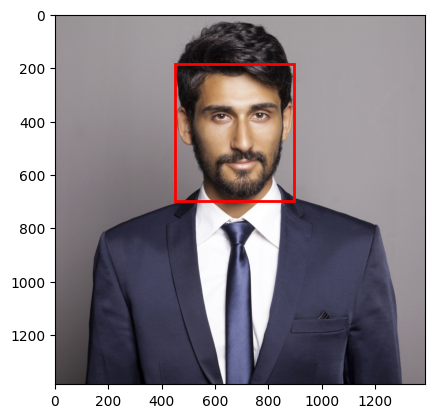

In [10]:
# Getting the full image filepath
sample_image_name = train.iloc[0]["name"]
sample_image_file_path = images_file_path + sample_image_name

# Select rows with the same image name as in the "name" column of the train dataframe
sel_df = train[train["name"] == sample_image_name]

# Convert all of the available "bbox" values into a list
bboxes = sel_df[["x1", "x2", "y1", "y2"]].values.tolist()

# Creating a figure and a sub-plot
fig, ax = plt.subplots()

# Reading in the image as an array
img = plt.imread(sample_image_file_path)

# Showing the image
ax.imshow(img)

# Plotting the bounding boxes
for box in bboxes:

    x1, x2, y1, y2 = box

    # x and y co-ordinates
    xy = (x1, x2)

    # Width of box
    width = y1 - x1

    # Height of box
    height = y2 - x2

    rect = patches.Rectangle(
        xy,
        width,
        height,
        linewidth=2,
        edgecolor="r",
        facecolor="none",
    )

    ax.add_patch(rect)

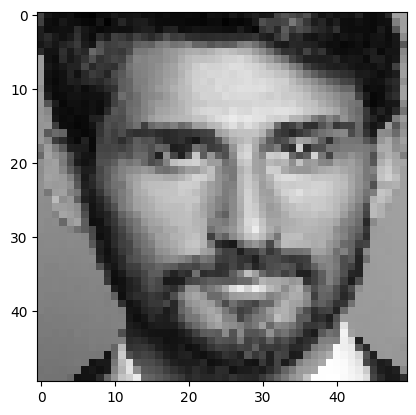

In [12]:
img_size = 50
data = []

for index, row in train.iterrows():

    # Single row
    name, x1, x2, y1, y2, classname = row.values

    # Full file path
    full_file_path = images_file_path + name

    # Reading in the image array as a grayscale image
    img_array = cv2.imread(full_file_path, cv2.IMREAD_GRAYSCALE)

    # Selecting the portion covered by the bounding box
    crop_image = img_array[x2:y2, x1:y1]

    # Resizing the image
    new_img_array = cv2.resize(crop_image, (img_size, img_size))

    # Appending the arrays into a data variable along with bounding box
    data.append([new_img_array, classname])

# Plotting one of the images after pre-processing
plt.imshow(data[0][0], cmap="gray")

In [13]:
# Initializing an empty list for features (independent variables)
x = []

# Initializing an empty list for labels (dependent variable)
y = []

for features, labels in data:
    x.append(features)
    y.append(labels)
# Reshaping the feature array (Number of images, IMG_SIZE, IMG_SIZE, Color depth)
x = np.array(x).reshape(-1, 50, 50, 1)

# Normalizing
x = normalize(x, axis=1)

# Label encoding y
lbl = LabelEncoder()
y = lbl.fit_transform(y)

# Converting it into a categorical variable
y = to_categorical(y)

#Defining the Deep learning architecture and training the model


In [14]:
input_img_shape = x.shape[1:]
# Initializing a sequential keras model
model = Sequential()

# Adding a 2D convolution layer
model.add(
    Conv2D(
        filters=100,
        kernel_size=(3, 3),
        use_bias=True,
        input_shape=input_img_shape,
        activation="relu",
        strides=2,
    )
)

# Adding a max-pooling layer
model.add(MaxPooling2D(pool_size=(2, 2)))

# Adding a 2D convolution layer - Output Shape = 10 x 10 x 64
model.add(Conv2D(filters=64, kernel_size=(3, 3), use_bias=True, activation="relu"))

# Adding a max-pooling layer - Output Shape = 5 x 5 x 64
model.add(MaxPooling2D(pool_size=(2, 2)))

# Adding a flatten layer - Output Shape = 5 x 5 x 64 = 1600
model.add(Flatten())

# Adding a dense layer - Output Shape = 50
model.add(Dense(50, activation="relu"))

# Adding a dropout
model.add(Dropout(0.2))

# Adding a dense layer with softmax activation
model.add(Dense(2, activation="softmax"))

# Printing the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 24, 24, 100)       1000      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 12, 12, 100)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 10, 10, 64)        57664     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 64)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 1600)              0         
                                                                 
 dense (Dense)               (None, 50)                8

In [15]:
# Initializing an Adam optimizer
opt = Adam(learning_rate=1e-3)

# Configuring the model for training
model.compile(optimizer=opt, loss="categorical_crossentropy", metrics=["accuracy"])

# Training the model
model.fit(x, y, epochs=30, batch_size=5)

Epoch 1/30
1150/1150 [==============================] - 18s 5ms/step - loss: 0.5561 - accuracy: 0.7285
Epoch 2/30
1150/1150 [==============================] - 4s 4ms/step - loss: 0.4720 - accuracy: 0.7671
Epoch 3/30
1150/1150 [==============================] - 5s 4ms/step - loss: 0.4192 - accuracy: 0.8149
Epoch 4/30
1150/1150 [==============================] - 6s 5ms/step - loss: 0.3798 - accuracy: 0.8304
Epoch 5/30
1150/1150 [==============================] - 4s 4ms/step - loss: 0.3475 - accuracy: 0.8433
Epoch 6/30
1150/1150 [==============================] - 5s 4ms/step - loss: 0.3112 - accuracy: 0.8685
Epoch 7/30
1150/1150 [==============================] - 5s 4ms/step - loss: 0.2912 - accuracy: 0.8763
Epoch 8/30
1150/1150 [==============================] - 4s 4ms/step - loss: 0.2689 - accuracy: 0.8855
Epoch 9/30
1150/1150 [==============================] - 5s 5ms/step - loss: 0.2531 - accuracy: 0.8906
Epoch 10/30
1150/1150 [==============================] - 4s 4ms/step - loss: 0.22

# Prediction and Testing

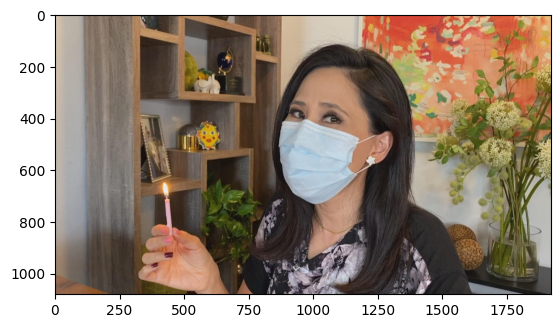

In [41]:
# Image file path for sample image
#test_image_file_path = "Medical mask/Medical mask/Medical Mask/images/0001.jpg"
test_image = "face_3.jpg"
# Loading in the image
img = plt.imread(test_image)

# Showing the image
plt.imshow(img)

In [42]:
# Initializing the detector
detector = MTCNN() #Multi-task Cascaded Convolutional Networks (MTCNN) is a framework developed as a solution for both face detection and face alignment

# Detecting the faces in the image
faces = detector.detect_faces(img)

print(faces)

1/1 [==============================] - 0s 199ms/step
[{'box': [878, 220, 320, 439], 'confidence': 0.9996510744094849, 'keypoints': {'left_eye': (961, 383), 'right_eye': (1102, 408), 'nose': (982, 493), 'mouth_left': (933, 557), 'mouth_right': (1053, 576)}}]


1/1 [==============================] - 0s 127ms/step


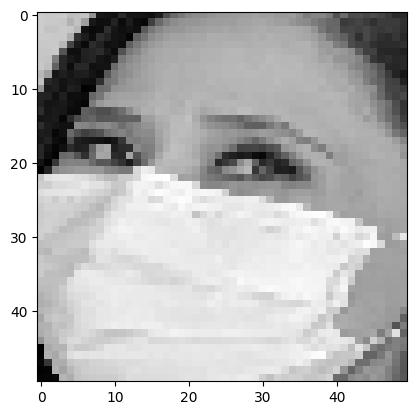

In [43]:
# Reading in the image as a grayscale image
img_array = cv2.imread(test_image, cv2.IMREAD_GRAYSCALE)

# Initializing the detector
detector = MTCNN()

# Detecting the faces in the image
faces = detector.detect_faces(img)

# Getting the values for bounding box
x1, x2, width, height = faces[0]["box"]

# Selecting the portion covered by the bounding box
crop_image = img_array[x2 : x2 + height, x1 : x1 + width]

# Resizing the image
new_img_array = cv2.resize(crop_image, (img_size, img_size))

# Plotting the image
plt.imshow(new_img_array, cmap="gray")

# Reshaping the image
x = new_img_array.reshape(-1, 50, 50, 1)

# Normalizing
x = normalize(x, axis=1)

In [45]:
prediction = model.predict(x)
print(prediction)
val = np.argmax(prediction)
print(val)
if val == 1:
  print("Mask")
else:
  print("No Mask")


1/1 [==============================] - 0s 22ms/step
[[1.3348704e-10 1.0000000e+00]]
1
Mask
